In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from math import acos
from scipy.linalg import solve

sns.set_theme(context='talk', style='darkgrid')
plt.style.use('fivethirtyeight')

In [40]:
dataDir    = '../Data/'
resultsDir = './2D/'
filename   = 'FullRetina_root_with_macula_stage_3.cco'
CCOFile    = resultsDir + filename
imagesDir  = CCOFile[:-4]+'/'

try:
    # Create target Directory
    os.mkdir(imagesDir)
    print("Directory " , imagesDir,  " Created ") 
except FileExistsError:
    print("Directory " , imagesDir,  " already exists")

Directory  ./2D/FullRetina_root_with_macula_stage_3/  already exists


In [41]:
def VerticalProjection(P):
    r = 1.14e04 # In microns
    Q = P
    Q[1:,-1]  = -(r**2 - P[1:,0]**2 - P[1:,1]**2)**0.5
    Q[0,:-1]  -= r  
    return Q

def StereographicProjection(P):
    r = 1.14e04
    Q = np.zeros_like(P)
    for i in range(P.shape[0]):
        if P[i,2] < 0:
            Q[i,:]  = [P[0,0], P[0,1], P[0,2]-r]
        else:
            h = P[i,0]**2 + P[i,1]**2
            Q[i,0] = r* 2*P[i,0]*r/(r**2+h)
            Q[i,1] = r* 2*P[i,1]*r/(r**2+h)
            Q[i,2] = r* (h-r**2)/(h+r**2)
    return Q

In [42]:
### Old version. Units (probably viscosity) were wrong

def Viscosity(d, hd=0.45, Type='Pries'):
    '''
    Diameter (d) should be in microns
    '''
    if Type=='Constant':
        return 3.6 # cP
    if Type=='Haynes':
        # Both muInf and delta are taken from Takahashi's model
        muInf = 1.09*np.exp(0.024*hd)
        delta = 4.29
        return muInf/( (1+delta/(d/2.0))**2 )
    else:
        mu045 = 220*np.exp(-1.3*d) + 3.2 - 2.44*np.exp(-0.06*d*0.645)
        C = (0.8 + np.exp(-0.075*d))*(-1+(1+10**-11*(d)**12)**-1)+(1+10**-11*(d)**12)**-1
        return ( 1 + (mu045-1)*((1-hd)**C-1)/((1-0.45)**C-1) )


def SolveFlow(Connectivity, Radii, Length, D, df, viscosityModel='Pries', Qperf=15.0):
        
    narcs, nnodes = Connectivity.shape
    R = np.zeros((narcs,narcs))
    for i in range(narcs):
        r,l = Radii[i], Length[i]  # In microns
        mu  = Viscosity(2*r, Type=viscosityModel) * 1e-6 # Converts to mum^-1.g.s^-1
        R[i,i] = 8.0*mu*l/(np.pi*(r**4))
    
    # Add the boundary conditions
    qperf = Qperf # in muL/min
    qcap  = 0.1 # muL/min, ignore

    # RHS for flow rates: qbar = qperf if inlet node, qcap otherwise
    qbar = np.ones((nnodes,)) # Flow rate at nodes
    qbar = np.matmul(D,qbar)
    convertmuL   = 1#1e9
    qbar[qbar>0] = qperf * convertmuL
    qbar[qbar<0] = qcap

    pbar = np.ones((nnodes,))
    pbar = D.dot(pbar)
    convertmmHg = 1.333224e-1 # To g.mum^1.s^-2
    pbar[pbar>0] = 50 * convertmmHg
    pbar[pbar<0] = 25 * convertmmHg
    
    D = np.abs(D)
    D[-1,-1] = 0 # Setting this entry to 0 allows to specify flow at inlet 
    I = np.identity(D.shape[0])
    
    M = np.block([[
    R, -Connectivity],
    [(I-D).dot(Connectivity.T), D]])
      
    RHS = np.concatenate([np.zeros(narcs,), (I-D).dot(qbar)+D.dot(pbar)])
    x = solve(M,RHS)
    f,p = np.abs(x[:narcs]), x[narcs:] / convertmmHg
    dp  = np.abs(Connectivity.dot(p))    
    
    for i in range(f.shape[0]):
        df.at[i,'CompFlow'] = df.at[i, 'Flow']
        df.at[i,'Flow'] = f[i] / convertmuL
        df.at[i,'PressureDrop'] = dp[i] 
        df.at[i,'Pressure'] = p[df.at[i,'DistalNode']]  + dp[i] 
    
    df['Viscosity'] = Viscosity(df.Radius.to_numpy()*2, Type=viscosityModel) 
    df['FlowVelocity'] = df.Flow.to_numpy() * convertmuL/(np.pi*(df.Radius.to_numpy()**2)) * 1e-3 # Converts flow in muL/s to mum^3/s then mm/s
    df['WSR'] = 8*df.FlowVelocity.to_numpy()*1e3/(2*df.Radius.to_numpy()) 
    df['WSS'] = df.Viscosity.to_numpy()*df.WSR.to_numpy() * 1e-2
    df['Diameter'] = df.Radius.to_numpy()*2.0
    df['Resistance'] = 8.0*df.Viscosity.to_numpy()*1e-6*df.Length.to_numpy()/(np.pi*(df.Radius.to_numpy()**4)) 
    # df['Resistance'] = df['Pressure'].max()/df['Flow'] 
    
    cols = ['Flow', 'Pressure', 'FlowVelocity', 'PressureDrop',
            'Boundary', 'Viscosity', 'WSR', 'WSS', 'Radius', 'Length', 
            'Bifurcation', 'Stage', 'Id',
            'ParentId', 'BranchesId',
            'xProx', 'xDist',
            'DistalNode', 'Diameter', 'Resistance']
    dfNew = df[cols]
    dfNew.set_index('Id', inplace=True, drop=False)
    
    print(f'Flow loss (C*f).sum() = {Connectivity.T.dot(df.Flow.to_numpy()).sum()}, with q_in={dfNew.Flow.max()}')
    print(f"Flow loss q_in-q_out = {df.loc[df.Boundary==1,'Flow'].sum() - df.loc[df.Boundary==-1, 'Flow'].sum()}")
    
    
    return dfNew

In [43]:
def Viscosity(d, hd=0.45, Type='Pries'):
    '''
    Diameter (d) should be in microns
    '''
    if Type=='Constant':
        return 3.6 # cP
    if Type=='Haynes':
        # Both muInf and delta are taken from Takahashi's model
        muInf = 1.09*np.exp(0.024*hd)
        delta = 4.29
        return muInf/( (1+delta/(d/2.0))**2 )
    else:
        mu045 = 220*np.exp(-1.3*d) + 3.2 - 2.44*np.exp(-0.06*d*0.645)
        C = (0.8 + np.exp(-0.075*d))*(-1+(1+10**-11*(d)**12)**-1)+(1+10**-11*(d)**12)**-1
        return ( 1 + (mu045-1)*((1-hd)**C-1)/((1-0.45)**C-1) )



In [44]:
# The length unit will be centimeter
lengthUnit = 'm'
if lengthUnit == 'cm':
    m_to_lengthUnit = 1e2
elif lengthUnit == 'mm':
    m_to_lengthUnit = 1e3
else:
    m_to_lengthUnit = 1.0
    
def SolveFlow(Connectivity, Radii, Length, D, df, viscosityModel='Pries', Qperf=15.0):
    
    muLmin_to_m3sec = 1e-9/60 * (m_to_lengthUnit**3)
    muLmin_to_mum3sec = 1e9/60 / (m_to_lengthUnit**3)
    mmHg_to_Pa = 133.3224 / m_to_lengthUnit # To Pa=kg.m^-1.s^-2
    cP_to_Pas  = 1e-3 / m_to_lengthUnit     # To Pa.s=kg.m^-1.s^-1
    micron_to_meter = 1e-6 * m_to_lengthUnit
    mum_to_mm = 1e-3 
    Pa_to_dynecm2 = 1e1

    narcs, nnodes = Connectivity.shape
    R = np.zeros((narcs,narcs))
    for i in range(narcs):
        r,l = Radii[i], Length[i]  # In meter
        mu  = Viscosity(2*r, Type=viscosityModel) * cP_to_Pas 
        # print(f'{r=} and {mu=}')
        R[i,i] = 8.0 * mu * l*micron_to_meter/(np.pi * ((r*micron_to_meter)**4))
    
    # Add the boundary conditions
    qperf = Qperf * muLmin_to_m3sec # Qperf is in muL/min, changed to m^3/s
    qcap  = qperf / df.value_counts('Boundary')[-1]

    # RHS for flow rates: qbar = qperf if inlet node, qcap otherwise
    qbar = np.ones((nnodes,)) # Flow rate at nodes
    qbar = np.matmul(D,qbar)
    qbar[qbar>0] = qperf 
    qbar[qbar<0] = qcap

    pbar = np.ones((nnodes,))
    pbar = D.dot(pbar)
    pbar[pbar>0] = 50 * mmHg_to_Pa
    pbar[pbar<0] = 25 * mmHg_to_Pa
    
    D = np.abs(D)
    # D[-1,-1] = 0 # Setting this entry to 0 allows to specify flow at inlet 
    I = np.identity(D.shape[0])
    
    M = np.block([[
    R, -Connectivity],
    [(I-D).dot(Connectivity.T), D]])
      
    RHS = np.concatenate([np.zeros(narcs,), (I-D).dot(qbar)+D.dot(pbar)])
    x = solve(M,RHS)
    f,p = np.abs(x[:narcs]), x[narcs:] / mmHg_to_Pa
    dp  = np.abs(Connectivity.dot(p)) / mmHg_to_Pa   
    
    for i in range(f.shape[0]):
        df.at[i,'CompFlow'] = df.at[i, 'Flow']
        df.at[i,'Flow'] = f[i] / muLmin_to_m3sec
        df.at[i,'PressureDrop'] = dp[i] 
        df.at[i,'Pressure'] = p[df.at[i,'DistalNode']]  + dp[i] 
    
    df['Viscosity'] = Viscosity(df.Radius.to_numpy()*2, Type=viscosityModel) # In cP
    df['FlowVelocity'] = df.Flow.to_numpy() * muLmin_to_mum3sec/(np.pi*(df.Radius.to_numpy()**2)) * mum_to_mm # Converts flow in muL/min to mum^3/min then mm/s
    df['WSR'] = 4*df.Flow.to_numpy() * muLmin_to_mum3sec /(np.pi*df.Radius.to_numpy()**3)  
    df['WSS'] = df.Viscosity.to_numpy()*df.WSR.to_numpy() * cP_to_Pas * Pa_to_dynecm2
    df['Diameter'] = df.Radius.to_numpy()*2.0
    df['Resistance'] = 8.0*df.Viscosity.to_numpy()*df.Length.to_numpy()/(np.pi*(df.Radius.to_numpy()**4)) * cP_to_Pas / (micron_to_meter**3) # Results in Pa.s.m^-3
    # df['Resistance'] = df['Pressure'].max()/df['Flow'] 
    
    cols = ['Flow', 'Pressure', 'FlowVelocity', 'PressureDrop',
            'Boundary', 'Viscosity', 'WSR', 'WSS', 'Radius', 'Length', 
            'Bifurcation', 'Stage', 'Id',
            'ParentId', 'BranchesId',
            'xProx', 'xDist',
            'DistalNode', 'Diameter', 'Resistance']
    dfNew = df[cols]
    dfNew.set_index('Id', inplace=True, drop=False)
    
    print(f'Flow loss (C*f).sum() = {Connectivity.T.dot(df.Flow.to_numpy()).sum()}, with q_in={dfNew.Flow.max()}')
    print(f"Flow loss q_in-q_out = {df.loc[df.Boundary==1,'Flow'].sum() - df.loc[df.Boundary==-1, 'Flow'].sum()}")
    
    
    return dfNew

In [45]:
def ReadCCO(CCOFile, project=True, treeType='Object'):
    
    SegmentsData = []
    DistalNodes  = dict()
    
    nodeName = -1

    with open(CCOFile, 'r') as f:
             
        print(f.readline().strip())
        token = f.readline().split()
        inletNode = ([float(xi) for xi in token[:3]])
        print(f"Inlet at {inletNode}")

        f.readline()
        print(f.readline().strip())
        nVessels = int(f.readline())
        print(f'The tree has {nVessels} vessels.')
        
        for i in range(nVessels):
            
            row = (f.readline()).split()
              
            nodeName+=1
            DistalNodes[int(row[0])] = nodeName
                
            if treeType=='Object':
                # Uncomment to keep vessels added in specific stages
                if True:
                # if int(row[-1]) > -2: 

                    # Id, xProx, xDist, radius, length, flow computed by CCO, distalNode, stage
                    SegmentsData.append([int(row[0]),
                    np.array([float(x) for x in row[1:4]])*1e4, 
                    np.array([float(x) for x in row[4:7]])*1e4,
                    float(row[12])*1e4,
                    np.linalg.norm(np.array([float(x) for x in row[1:4]])*1e4
                                   -np.array([float(x) for x in row[4:7]])*1e4),
                    float(row[13]),
                    nodeName,
                    int(row[-1])])
                    

            else:
                # Id, xProx, xDist, radius, length, flow computed by CCO, distalNode, vesselId (for multiple segments vessels?)
                SegmentsData.append([int(row[0]),
                np.array([float(x) for x in row[1:4]])*1e4, 
                np.array([float(x) for x in row[4:7]])*1e4,
                float(row[8])*1e4,
                float(row[10])*1e4,
                float(row[11]),
                nodeName,
                int(row[-2])])
                
        if treeType=='Object':            
            df = pd.DataFrame(SegmentsData, columns=['Id', 'xProx', 'xDist', 'Radius', 'Length', 'Flow','DistalNode','Stage'])
        else:
            df = pd.DataFrame(SegmentsData, columns=['Id', 'xProx', 'xDist', 'Radius', 'Length', 'Flow','DistalNode','Stage'])

        df['Inlet'] = False
        df['Outlet'] = False
        df = df.set_index('Id', drop=False)
        df['ParentId'] = -1
        df['BranchesId'] = [[] for i in range(df.shape[0])]
    
        f.readline()
        print(f.readline().strip())
        
        NodesConnections = []
        SegNewName = -1
        for i in range(nVessels):
            row = (f.readline()).split()
            SegmentId, ParentId, BranchesIds = int(row[0]), int(row[1]), [int(x) for x in row[2:]]

            if SegmentId in DistalNodes:    
                ProximalNode = DistalNodes[SegmentId]
                branchesId = []
                for connection in BranchesIds:
                    DistalNode = DistalNodes[connection]
                    SegNewName +=1
                    NodesConnections.append((ProximalNode, DistalNode, SegNewName, connection))
                    branchesId.append(connection)
                df.at[SegmentId, 'BranchesId'] = branchesId    
                
                if not BranchesIds:
                    df.at[SegmentId, 'Outlet'] = True
                
                if not ParentId in DistalNodes: # Inlet node, need to add the proximal node to the tree
                    df.at[SegmentId, 'Inlet'] = True
                    nodeName+=1
                    SegNewName +=1
                    NodesConnections.append((nodeName, DistalNodes[SegmentId], SegNewName, SegmentId))
                else:
                    df.at[SegmentId, 'ParentId'] = ParentId

    
    ## Gives each inlet and its downstream branches a number
    def AssignBranchNumberToDownstreamVessels(InletIdx, branchNumber):
        
        # branchNumber = df.at[InletIdx, 'BranchNumber']
        branches = df.at[InletIdx, 'BranchesId']
        
        for branchId in branches:
            branchIdx = df[df.Id==branchId].index[0]
            df.at[branchIdx, 'BranchNumber'] = branchNumber
            df.at[branchIdx, 'Bifurcation']  = df.at[InletIdx,'Bifurcation']+1 
            AssignBranchNumberToDownstreamVessels(branchIdx, branchNumber)       
        
    df['BranchNumber'] = -1
    df['Bifurcation']  = 0
    for i,row in enumerate(df[df.Inlet].iterrows()):
        df.at[row[0], 'BranchNumber'] = i        
        AssignBranchNumberToDownstreamVessels(row[0],i)
                    
    # Project from the plane to the sphere
    if project:
        radiusEyeball = 23e3
        # xProx = ProjectOnSphere(np.vstack(df['xProx'].to_numpy().ravel()), r=radiusEyeball)
        # xDist = ProjectOnSphere(np.vstack(df['xDist'].to_numpy().ravel()), r=radiusEyeball)
        xProx = StereographicProjection(np.vstack(df.xProx.to_numpy().ravel()))
        xDist = StereographicProjection(np.vstack(df.xDist.to_numpy().ravel()))
        df['xProx'] = [xProx[i,:] for i in range(xProx.shape[0])] 
        df['xDist'] = [xDist[i,:] for i in range(xDist.shape[0])]
        df['Length'] = np.linalg.norm(xProx-xDist, axis=1)

    ## Create the matrices for the solver
    ConnectivityMatrix = np.zeros((nodeName+1, len(SegmentsData)))
    Radii  = np.zeros((len(SegmentsData),))
    Length = np.zeros((len(SegmentsData),))
    df['SegName'] = df.index
    df['Id'] = df.index
    df['Boundary'] = 0
    D = np.zeros((nodeName+1,nodeName+1)) # Decision matrix

    for proxNode, distNode, SegmentName, SegmentId in NodesConnections:
        
        ConnectivityMatrix[proxNode, SegmentName] = 1
        ConnectivityMatrix[distNode, SegmentName] = -1
        Radii[SegmentName] = df.at[SegmentId, 'Radius']
        xProx, xDist = df.at[SegmentId, 'xProx'], df.at[SegmentId, 'xDist']
        Length[SegmentName] = np.linalg.norm(xProx-xDist) 
        
        df.at[SegmentId, 'SegName'] = SegmentName
        if df.at[SegmentId, 'Inlet']:
            df.at[SegmentId,'Boundary'] = 1
            D[proxNode, proxNode] = 1
        elif df.at[SegmentId, 'Outlet']:
            df.at[SegmentId,'Boundary'] = -1
            D[distNode, distNode] = -1
    
    df = df.set_index('SegName')
               
    return ConnectivityMatrix.T, Radii, Length, D, df

In [46]:
C, Radii, Length, D, df = ReadCCO(CCOFile, project=True)
df.loc[df.Length==0]

*Tree
Inlet at [0.0, 0.0, -0.1]
*Vessels
The tree has 1101 vessels.
*Connectivity


,Id,xProx,xDist,Radius,Length,Flow,DistalNode,Stage,Inlet,Outlet,ParentId,BranchesId,BranchNumber,Bifurcation,Boundary
SegName,,,,,,,,,,,,,,,


In [47]:
df = SolveFlow(C, Radii, Length, D, df, viscosityModel='Pries', Qperf=15)

Flow loss (C*f).sum() = -3.552713678800501e-15, with q_in=12.913691612475525
Flow loss q_in-q_out = -3.801403636316536e-13


[(-0.1, 3.0)]

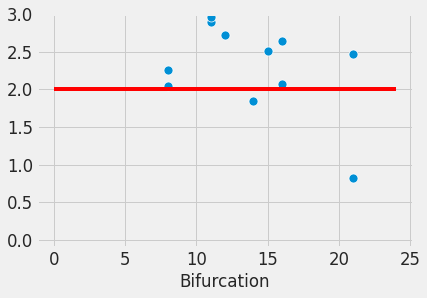

In [48]:
g = sns.scatterplot(x=df.Bifurcation, y=df.Length/df.Radius)
g.plot([0,df.Bifurcation.max()], [2,2], c='red')
g.set(ylim=(-0.1,3))

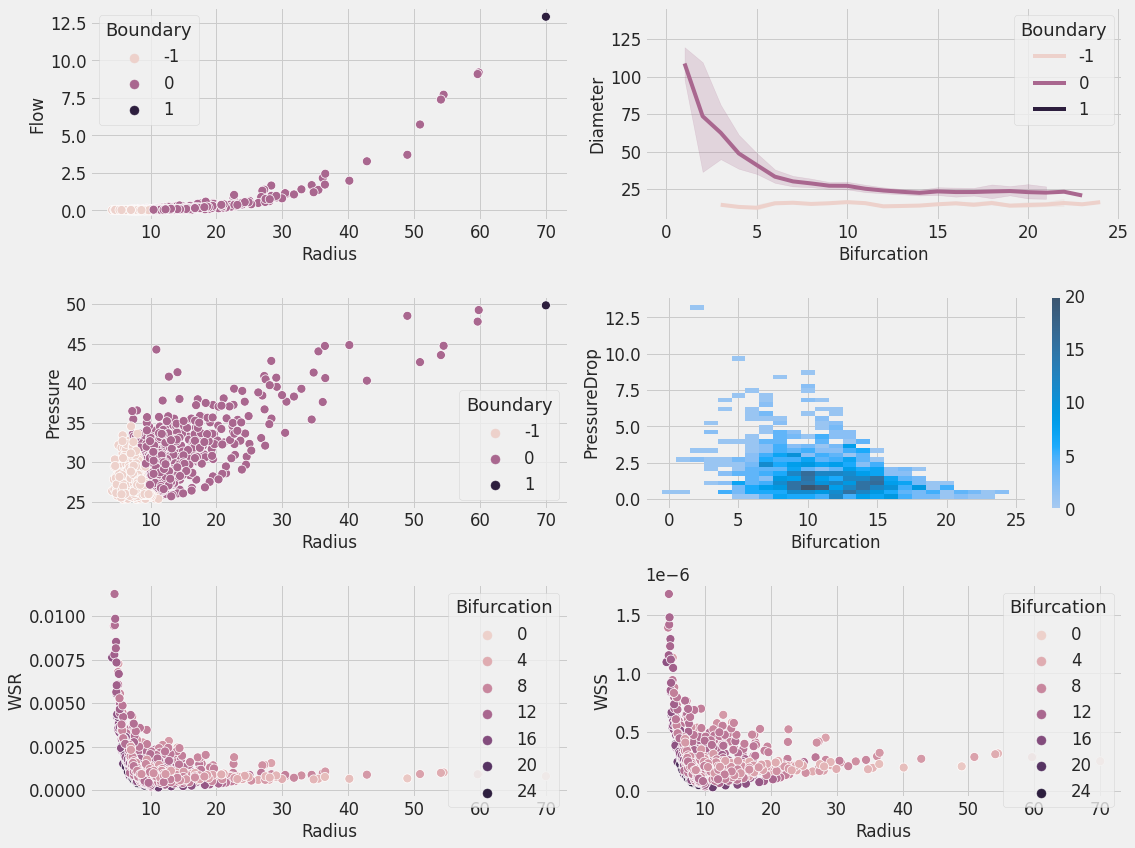

In [49]:
'''
Units should be:
    - Length (and volumes) in microns
    - Time in seconds
    - Pressure in mmHg
    - Wall shear rate in s^-1
    - Wall shear stress in dyn.cm^2 (=0.1Pa)
'''


scale=False
if scale:
    df.Flow = df.Flow/df.Flow.max()
    
    
fig, axes = plt.subplots(3,2, figsize=(16,12),sharex='none', sharey='none')
#fig.tight_layout()
axes = axes.ravel()
for ax in axes:
    ax.set(yscale='linear')
sns.scatterplot(data=df, x='Radius', y='Flow', hue='Boundary', ax=axes[0])
sns.scatterplot(data=df, x='Radius', y='Pressure', hue='Boundary', ax=axes[2])
sns.lineplot(data=df, x='Bifurcation', y='Diameter', hue='Boundary', ax=axes[1])
#sns.scatterplot(data=df, x='Radius', y='Pressure', hue='Boundary', ax=axes[3])
axes[3].set(yscale='linear')
sns.histplot(data=df, y='PressureDrop', x='Bifurcation', discrete=(True, False), cbar=True, ax=axes[3])

sns.scatterplot(data=df, x='Radius', y='WSR', hue='Bifurcation', ax=axes[4])
sns.scatterplot(data=df, x='Radius', y='WSS', hue='Bifurcation', ax=axes[5])

fig.tight_layout()
fig.savefig(imagesDir + 'Haemodynamics.jpg', dpi=300)

# Comparing 1<sup>st</sup> and 2<sup>nd</sup> order arterioles
Data from:
* [Nagaoka 2006](https://iovs.arvojournals.org/article.aspx?articleid=2182855)
* [Takahashi 2001](https://link.springer.com/article/10.1007/s12573-009-0012-1)

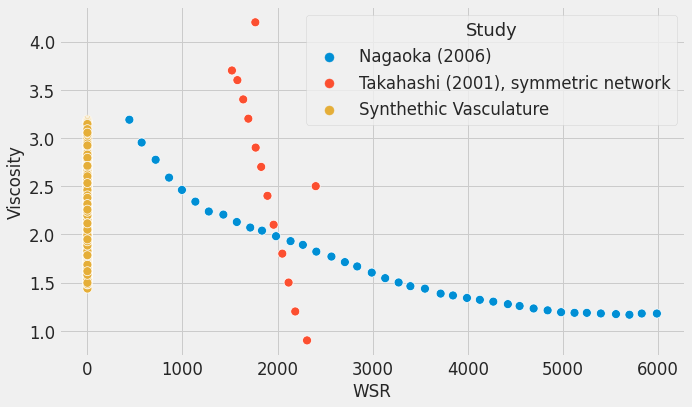

In [50]:
## !!! The data has been scaled to match the synthetic vasculature's values
dataVisc = pd.read_csv(dataDir + 'Viscosity-vs-ShearRate.csv', skipinitialspace=True)
dataVisc.loc[dataVisc['Study']=='Nagaoka (2006)','Viscosity'] = dataVisc.loc[dataVisc['Study']=='Nagaoka (2006)','Viscosity']/dataVisc['Viscosity'].max()*df['Viscosity'].max()

dataVisc = pd.concat((dataVisc,
                     pd.DataFrame([[wsr, visc, 'Synthethic Vasculature'] 
                                   for wsr,visc in zip(df.WSR.values, df.Viscosity.values)], 
                                  columns=dataVisc.columns)))

fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=dataVisc, x='WSR', y='Viscosity', hue='Study', ax=ax)
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#fig.tight_layout()
fig.savefig(imagesDir + 'Viscosity-vs-WSR.jpg', dpi=300)

In [51]:
dataHaemodynamics = pd.read_csv(dataDir + 'HaemodynamicsFirstAndSecondOrder.csv', skipinitialspace=True)
dataToPlot = ['Diameter', 'FlowVelocity', 'Flow', 'Resistance', 'WSR', 'Viscosity', 'WSS']

for measurementData, measurementSynth in zip(dataHaemodynamics.columns.values[2:], dataToPlot):
    print(measurementData)
    print('\tOrder\tData\tSynthetic vessels')
    for bif in [1,2]:
        data = dataHaemodynamics.loc[(dataHaemodynamics.Bifurcation==bif-1)
                                     & (dataHaemodynamics['Vessel type']=='Artery')][measurementData].values[0]
        synth = df.loc[df.Bifurcation==bif][measurementSynth].mean()
        nVessels = df.loc[df.Bifurcation==bif][measurementSynth].shape[0]
        print(f'\t{bif+1}\t{data}\t{synth} +- {df.loc[df.Bifurcation==bif][measurementSynth].std()} (mean of {nVessels} vessels)')

Diameter
	Order	Data	Synthetic vessels
	2	107.9	108.78535654175892 +- 15.32207608268412 (mean of 2 vessels)
	3	100.6	73.5839844769217 +- 40.08516435415302 (mean of 4 vessels)
Vmax (mm/s)
	Order	Data	Synthetic vessels
	2	41.1	1.0928975951412832e-05 +- 3.839275933532077e-06 (mean of 2 vessels)
	3	27.7	7.940760638738837e-06 +- 3.857659735766477e-06 (mean of 4 vessels)
Blood flow (L/min)
	Order	Data	Synthetic vessels
	2	11.4	6.456845806237945 +- 3.8791843459756983 (mean of 2 vessels)
	3	6.6	3.228422903118942 +- 3.997264242805433 (mean of 4 vessels)
Vascular resistance (mmHg.min/L)
	Order	Data	Synthetic vessels
	2	5.3	42803.787526656044 +- 51325.603816863695 (mean of 2 vessels)
	3	-	3423708.2251464827 +- 6593610.511292824 (mean of 4 vessels)
WSR (/s)
	Order	Data	Synthetic vessels
	2	1539	0.0007916787526614727 +- 0.00017083223310298463 (mean of 2 vessels)
	3	1119	0.0010182241451623748 +- 0.0005041124756999193 (mean of 4 vessels)
Apparent viscosity at WSR (cP)
	Order	Data	Synthetic vessels
	2

# Blood flow 
Data from:

    - https://opg.optica.org/boe/fulltext.cfm?uri=boe-5-2-630&id=277856 (FD Dopler OCT)
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4465795/ (fluorescent RBC - rats)
    - https://iovs.arvojournals.org/article.aspx?articleid=2159754 (bidirectional Dopler velocimetry + fundus photograph)
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9456494/ (Dopler OCT)
    - https://diabetesjournals.org/diabetes/article-abstract/doi/10.2337/db22-0219/147603/Retinal-Oxygen-Metabolism-in-Patients-with-Type-II?redirectedFrom=fulltext (Dopler OCT)
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8525846/ (Doplet OCT)

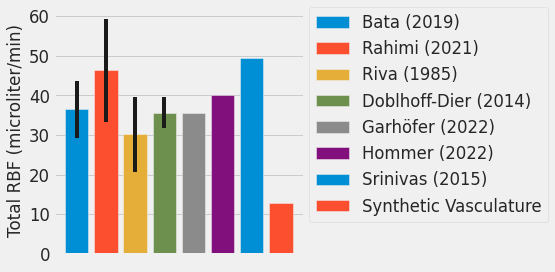

In [52]:
totalRBF = pd.read_csv(dataDir+'TotalRetinalBloodFlow.csv', skipinitialspace=True)
#totalRBF.at[totalRBF.shape[0]] = [df.Flow.sum(), 'Synthetic Vasculature (sum of all flows)', np.nan]
totalRBF.at[totalRBF.shape[0]] = [df.Flow.max(), 'Synthetic Vasculature', np.nan]

fig, ax = plt.subplots(figsize=(8,4))
for i, study in enumerate(totalRBF.Study.value_counts().index.to_list()):
    mean = totalRBF.loc[totalRBF.Study==study].mean(numeric_only=True).values
    std  = totalRBF.loc[totalRBF.Study==study].std(numeric_only=True).values
    ax.bar(i, mean[0], yerr=std[0], label=study)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xticks([])
ax.set_ylabel('Total RBF (microliter/min)')

fig.tight_layout()
fig.savefig(imagesDir + 'TotalRetinalBF.jpg', dpi=300)

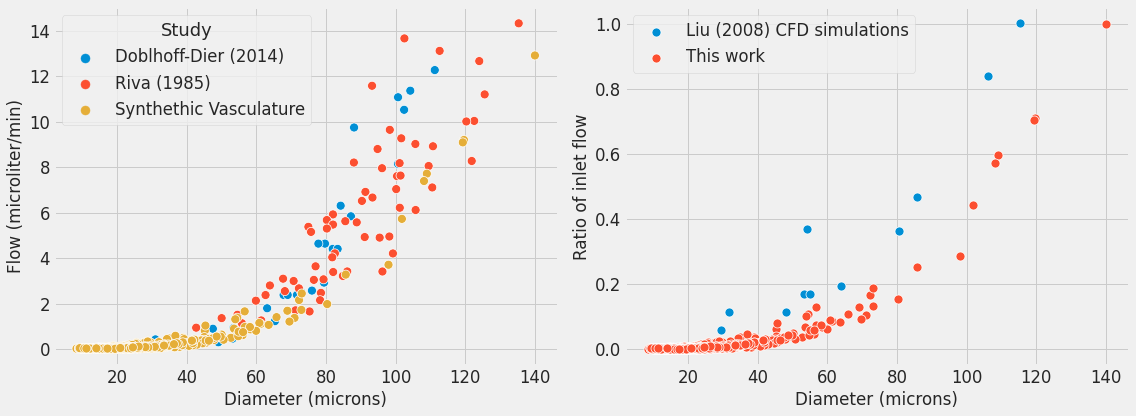

In [53]:
dataFlow = pd.read_csv(dataDir+'Flow-vs-Diameter.csv', skipinitialspace=True)
dataFlow = pd.concat((dataFlow.loc[dataFlow.Study!='Kornfield (2015)'],
                      pd.DataFrame([[d,f,'Synthethic Vasculature']
                              for d,f in zip(df.Diameter.values, df.Flow.values)], columns=dataFlow.columns)),
                    ignore_index=True)
CFD = pd.read_csv(dataDir + 'CFD_Liu_2008.csv', skipinitialspace=True)

fig, axes = plt.subplots(1,2, figsize=(16,6))
axes = axes.ravel()

sns.scatterplot(data=dataFlow, x=dataFlow.columns[0], y=dataFlow.columns[1], hue='Study', ax=axes[0])
#axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

sns.scatterplot(data=CFD, x='Diameter (microns)', y='Ratio of inlet flow', ax=axes[1])
sns.scatterplot(x=df['Diameter'].to_numpy(), y=df['Flow']/df['Flow'].max(), ax=axes[1])
axes[1].legend(['Liu (2008) CFD simulations', 'This work'])

fig.tight_layout()
fig.savefig(imagesDir + 'Flow_vs_Diameter.jpg', dpi=300)

# Branching analysis
Data from:
* [Zamir 1982](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2215753/)

In [54]:
# Compute the branching angles and caliber ratios

dldp, dsdl, dsdp = [], [], []
theta_s, theta_l = [], []

for idx, v in df.loc[df.Boundary!=-1].iterrows():

    branchesIdx = v.BranchesId
    branchesRadius = df.loc[branchesIdx, 'Radius'].to_numpy()         
    dldp.append(branchesRadius.max()/v.Radius)
    dsdp.append(branchesRadius.min()/v.Radius)
    dsdl.append(branchesRadius.min()/branchesRadius.max())    

    largerDescendentIdx  = branchesIdx[np.argmax(branchesRadius)]
    smallerDescendentIdx = branchesIdx[np.argmin(branchesRadius)]

    parentSegment  = (df.at[idx, 'xDist'] - df.at[idx, 'xProx'])/df.at[idx, 'Length']
    largerSegment  = ((df.at[largerDescendentIdx, 'xDist'] - df.at[largerDescendentIdx, 'xProx'])
                      /df.at[largerDescendentIdx, 'Length'])
    smallerSegment = ((df.at[smallerDescendentIdx, 'xDist'] - df.at[smallerDescendentIdx, 'xProx'])
                      /df.at[smallerDescendentIdx, 'Length'])

    # Check we have normalized properly
    if np.linalg.norm(parentSegment) != 1.0:
        parentSegment /= np.linalg.norm(parentSegment)
    if np.linalg.norm(largerSegment) != 1.0:
        largerSegment /= np.linalg.norm(largerSegment)
    if np.linalg.norm(smallerSegment) != 1.0:
        smallerSegment /= np.linalg.norm(smallerSegment)
    
    # Sometimes, a 'branch' is just the continuation of a vessel and has the same direction (theta < 1e-3 rad)
    dotProdLarger  = parentSegment.dot(smallerSegment)
    dotProdSmaller = parentSegment.dot(largerSegment)
    
    np.seterr(all='raise')
    try:
        theta = np.arccos(dotProdLarger)
    except FloatingPointError:
        theta = np.nan
    if theta < 1e-3:
        theta = np.nan
    theta_l.append(theta)

    try:
        theta = np.arccos(dotProdSmaller)
    except FloatingPointError:
        theta = np.nan
    if theta < 1e-3:
        theta = np.nan
    theta_s.append(theta) 
            
branching = pd.read_csv(dataDir+'Branching.csv', skipinitialspace=True)
branching = pd.concat((branching, 
                      pd.DataFrame([[ds_dl, dl_dp, ds_dl, ds_dp, ds_dl, 
                                     thetal, ds_dl, thetas, 'Synthetic Vasculature']
                                    for ds_dl, dl_dp,
                                     ds_dp, thetal, thetas in zip(dsdl, dldp, dsdp, theta_l, theta_s)], 
                                   columns=branching.columns.values)))

# Sort the data into bins for plotting
branching['bins_thetal'] = pd.cut(branching['ds/dl_theta_l'], 50).astype(str)
branching['bins_thetas'] = pd.cut(branching['ds/dl_theta_s'], 50).astype(str)

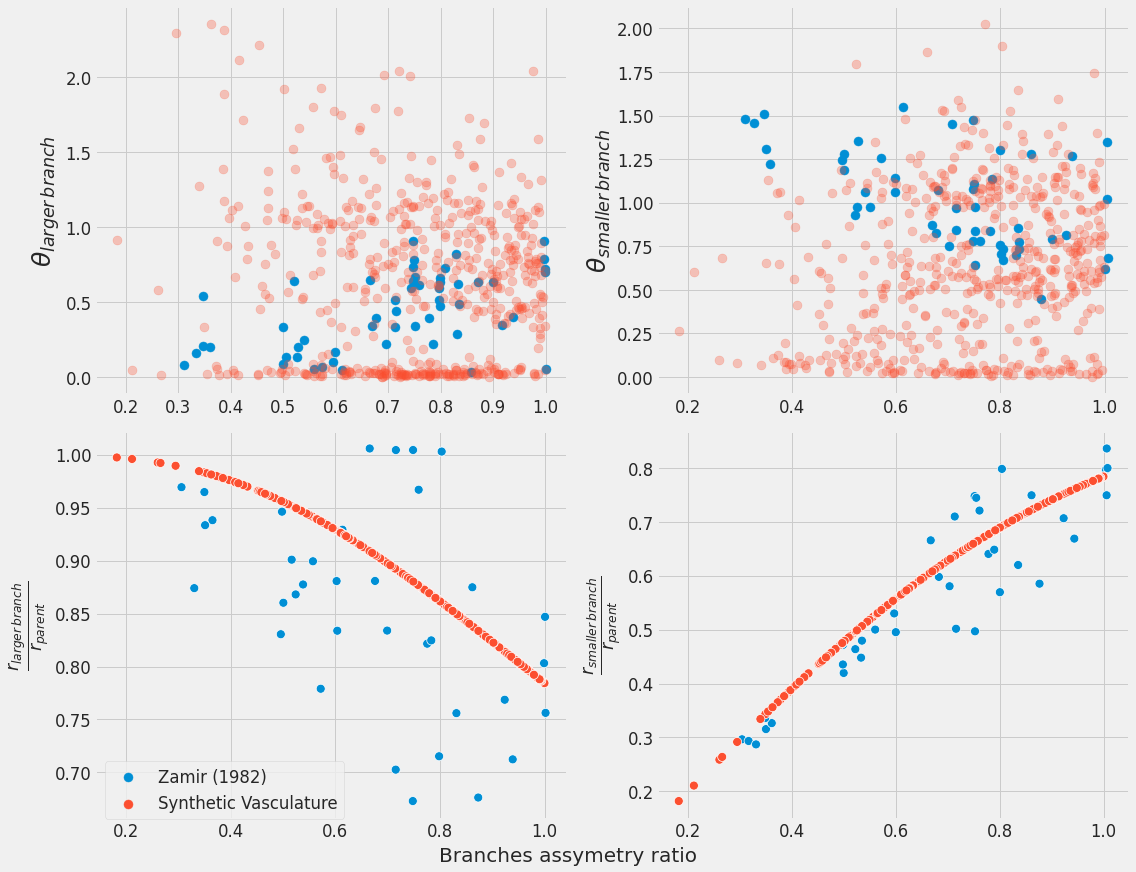

In [55]:
fig, axes = plt.subplots(2,2, figsize=(16,12), sharex='none', sharey='none')
axes = axes.ravel()

#sns.scatterplot(data=df, x='Radius', y='Length', ax=ax[0])
alpha = 0.3
# sns.scatterplot(data=branching, x='ds/dl_theta_l', y='theta_l', hue='Study',
#              ax=axes[0], legend=False)
# sns.scatterplot(data=branching, x='ds/dl_theta_s', y='theta_s', hue='Study',
#              ax=axes[1], legend=False)

axes[0].scatter(branching.loc[branching.Study!='Synthetic Vasculature', 'ds/dl_theta_l'].to_numpy(),
                branching.loc[branching.Study!='Synthetic Vasculature', 'theta_l'].to_numpy(), alpha=1)
axes[0].scatter(branching.loc[branching.Study=='Synthetic Vasculature', 'ds/dl_theta_l'].to_numpy(),
                branching.loc[branching.Study=='Synthetic Vasculature', 'theta_l'].to_numpy(), alpha=alpha)

axes[1].scatter(branching.loc[branching.Study!='Synthetic Vasculature', 'ds/dl_theta_s'].to_numpy(),
                branching.loc[branching.Study!='Synthetic Vasculature', 'theta_s'].to_numpy(), alpha=1)
axes[1].scatter(branching.loc[branching.Study=='Synthetic Vasculature', 'ds/dl_theta_s'].to_numpy(),
                branching.loc[branching.Study=='Synthetic Vasculature', 'theta_s'].to_numpy(), alpha=alpha)


### !!!! Shifts the values of the data to the left axis
# sns.pointplot(data=branching, x='bins_thetal', y='theta_l', hue='Study', errorbar='sd', 
#               markers='.', ax=axes[0], legend=False, linestyles='none')
# sns.pointplot(data=branching, x='bins_thetas', y='theta_s', hue='Study', errorbar='sd', 
#               markers='.', ax=axes[1], legend=False, linestyles='none')
# axes[0].get_legend().remove()
# axes[1].get_legend().remove()
# axes[0].set_xticklabels('')
# axes[1].set_xticklabels('')


sns.scatterplot(data=branching, x='ds/dl_dl/dp', y='dl/dp', hue='Study', ax=axes[2], legend=True)
axes[2].legend(bbox_to_anchor=(.02, 0), loc='lower left', borderaxespad=0)
sns.scatterplot(data=branching, x='ds/dl_ds/dp', y='ds/dp', hue='Study', ax=axes[3], legend=False)

fig.text(0.5, 0.0, 'Branches assymetry ratio', ha='center', va='center', fontsize=20)
axes[0].set_ylabel(r'$\theta_{larger\,branch}$', fontsize=25)
axes[1].set_ylabel(r'$\theta_{smaller\,branch}$', fontsize=25)
axes[2].set_ylabel(r'$\frac{r_{larger\,branch}}{r_{parent}}$', fontsize=25)
axes[3].set_ylabel(r'$\frac{r_{smaller\,branch}}{r_{parent}}$', fontsize=25)
for ax in axes:
    ax.set_xlabel('')

fig.tight_layout()
fig.savefig(imagesDir + 'BranchingBehaviour.jpg', dpi=300)

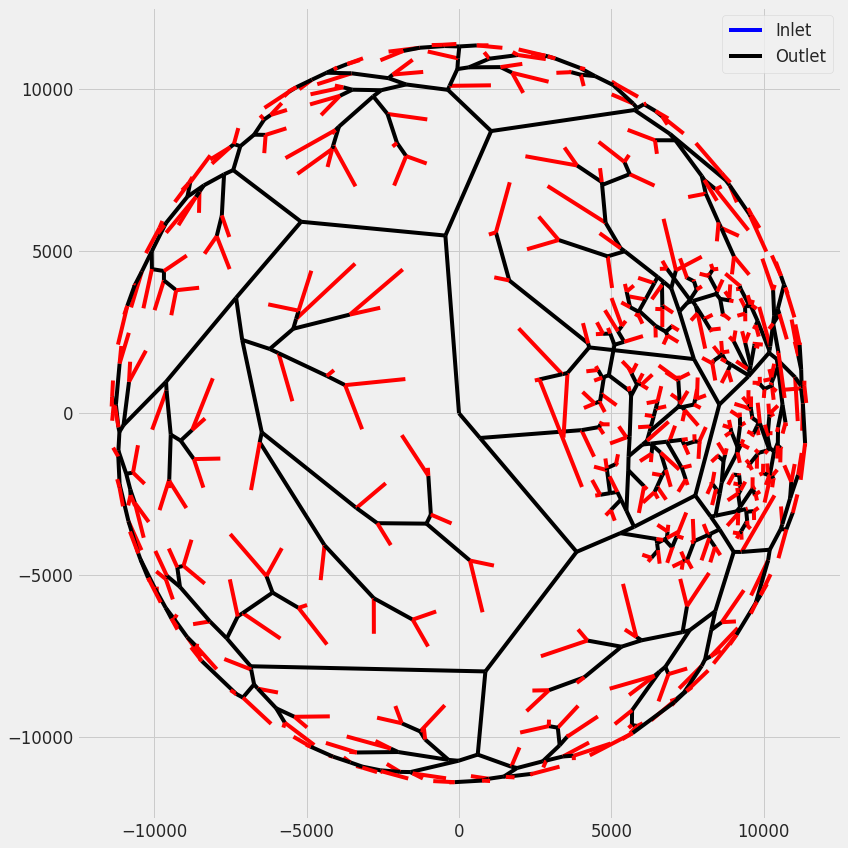

In [56]:
fig = plt.figure(figsize=(12,12))
for idx, v in df.iterrows():
    # Print the connections
    xIn,yIn, _   = v.xProx
    xOut,yOut, _ = v.xDist
    if v.Boundary==1:
        plt.plot([xIn,xOut], [yIn, yOut], c='blue', label='Inlet')
    elif v.Boundary==-1:
        plt.plot([xIn,xOut], [yIn, yOut], c='red', label='Outlet')
    else:
        plt.plot([xIn,xOut], [yIn, yOut], c='black')
        
plt.legend(['Inlet', 'Outlet'])
fig.tight_layout()
fig.savefig(imagesDir + 'Visu.jpg')

In [57]:
import vtk

vtkTree = vtk.vtkPolyData()
points  = vtk.vtkPoints()
lines   = vtk.vtkCellArray()
nodeDataRadius = vtk.vtkDoubleArray()
cellDataRadius = vtk.vtkDoubleArray()
cellDataFlow   = vtk.vtkDoubleArray()
cellDataStage  = vtk.vtkDoubleArray()

nodeDataRadius.SetName('Radius')
cellDataRadius.SetName('Radius')
cellDataFlow.SetName('Flow')
cellDataStage.SetName('Stage')

for idx, v in df.iterrows():
    idProx = points.InsertNextPoint(v.xProx)
    nodeDataRadius.InsertNextValue(v.Radius)
    idDist = points.InsertNextPoint(v.xDist)
    nodeDataRadius.InsertNextValue(v.Radius)

    vtkSegment = vtk.vtkLine()
    vtkSegment.GetPointIds().SetId(0, idProx)
    vtkSegment.GetPointIds().SetId(1, idDist)

    lines.InsertNextCell(vtkSegment)
    cellDataFlow.InsertNextValue(v.Flow)
    cellDataRadius.InsertNextValue(v.Radius)
    cellDataStage.InsertNextValue(v.Stage)

vtkTree.SetPoints(points)
vtkTree.SetLines(lines)

vtkTree.GetPointData().AddArray(nodeDataRadius)

vtkTree.GetCellData().AddArray(cellDataFlow)
vtkTree.GetCellData().AddArray(cellDataRadius)
vtkTree.GetCellData().AddArray(cellDataStage)

writer = vtk.vtkXMLPolyDataWriter()
writer.SetFileName(imagesDir + filename[:-4]+'.vtp')
writer.SetInputData(vtkTree)
writer.SetDataModeToBinary()
writer.Write()

print("Output writen in " + writer.GetFileName())


Output writen in ./2D/FullRetina_root_with_macula_stage_3/FullRetina_root_with_macula_stage_3.vtp
